Using updated dataset of the 06/01/2022 (initially 510 files)


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
import zarr
import geopy.distance
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from datetime import datetime

# Reference methods for regression and maths
import pickle
import sklearn.linear_model
from sklearn import metrics
from sklearn import svm
from pygam import LinearGAM, s, l, f
from pygam.terms import TermList
import statsmodels.api as sm
from scipy import stats

# Custom
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [2]:
### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))

### OLD VERSION
# ds = xr.open_dataset('/home/arthur/data/cyclobs/old_files_06012022/s1b-ew-owi-ca-20180811t052613-20180811t052854-000003-0167F5_sw_ep102018_cyclone.nc')
# ds
# plt.subplot(projection = "polar")
# r, th = np.meshgrid(ds['rad'], ds['theta'])
# th    = 90 - th - 63 # rotation angle is ~63°
# th    = np.deg2rad(th)
# plt.pcolormesh(th, r, ds['wind_speed'][0, :, :]);plt.colorbar()
# plt.show()

Total number of files: 341


In [3]:
ds    = xr.open_dataset(all_data[0])
ds_an = xr.open_dataset(all_data[0], group='analysis')
ds

<xarray.Dataset>
Dimensions:                                        (time: 1, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2021...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/32)
    lon                                            (time, x, y) float64 ...
    lat                                            (time, x, y) float64 ...
    wind_from_direction                            (time, x, y) float64 ...
    heterogeneity_mask                             (time, x, y) float64 ...
    nrcs_detrend_co                                (time, x, y) float64 ...
    wind_streaks_orientation                       (time, x, y) float64 ...
    ...                                             ...
    radial_wind_parametrized                       (time, x, y) float64 ...
    tangential_wind_parametrized                   (time, x, y) float64 ...
    across_wind_parametrized                       (time, x, y) float64 ...
    along_wind_parametrized                        (time, x, y) float64 ...
    meridional_interp_parametrized                 (time, x, y) float64 ...
    zonal_interp_parametrized                      (time, x, y) float64 ...

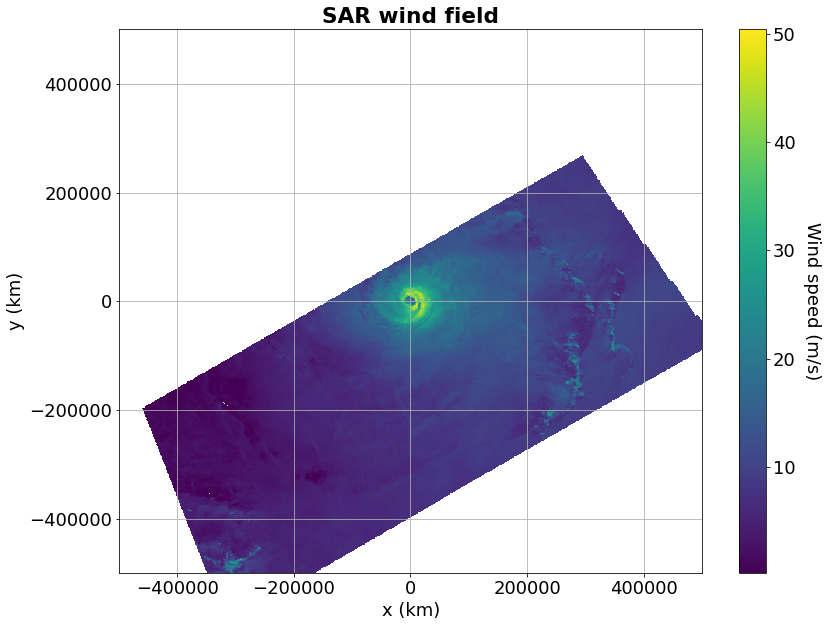

In [4]:
### DISPLAY TC WIND FIELD IN CARTESIAN COORDINATES
fig, _ = plt.subplots()
plt.title('SAR wind field', weight='bold')
x, y = np.meshgrid(ds['x'], ds['y'])
plt.pcolormesh(x, y, ds['wind_speed'][0, :, :])
plt.xlabel('x (km)');plt.ylabel('y (km)');plt.grid()
plt.subplots_adjust(right=0.8)
cbar = plt.colorbar()
cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25

In [5]:
%%time
### PARALLEL
all_data = glob.glob(dir_path + "*.nc")
from dask.diagnostics import ProgressBar

@da.delayed
def plot(file):
    # Open file
    ds          = xr.open_dataset(file)
    
    # Get additional information
    ds_analysis = xr.open_dataset(file, group="analysis")
    TC_cat      = du.get_cat_as_nb(ds_analysis)
    TC_name     = ds_analysis.attrs['Storm name']
    TC_id       = ds_analysis.attrs['Storm ID']
    
    # Plot
    fig, _ = plt.subplots()
    plt.title('SAR wind field\n%s, %s'%(TC_name, TC_id) + ', Cat. %i'%TC_cat, weight='bold')
    
    x, y = np.meshgrid(ds['x'], ds['y'])
    plt.pcolormesh(x, y, ds['wind_speed'][0, :, :])
    
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()
    plt.subplots_adjust(right=0.8)
    cbar = plt.colorbar()
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25
    
    # Save
    fig.set_size_inches(25, 18)
    plt.savefig('/home/arthur/results/bigData2022_covariance/341_files_rotated_cartesian/' + os.path.splitext(os.path.basename(file))[0] + '.jpg', dpi=100)

# Uncomment to save the plots
# tasks = [plot(file) for file in all_data]
# with ProgressBar():
#     # da.compute(tasks, scheduler='processes', num_workers=32)
#     da.compute(tasks, scheduler='processes')

CPU times: user 3.63 ms, sys: 0 ns, total: 3.63 ms
Wall time: 2.49 ms


In [6]:
# %%time
# ### SEQUENTIAL

# for file in tqdm(all_data[:20]):
#     # Open file
#     ds          = xr.open_dataset(file)
    
#     # Get additional information
#     ds_analysis = xr.open_dataset(file, group="analysis")
#     TC_cat      = du.get_cat_as_nb(ds_analysis)
#     TC_name     = ds_analysis.attrs['Storm name']
#     TC_id       = ds_analysis.attrs['Storm ID']
    
#     # Plot
#     fig, _ = plt.subplots()
#     plt.title('SAR wind field\n%s, %s'%(TC_name, TC_id) + ', Cat. %i'%TC_cat, weight='bold')
#     plt.pcolormesh(ds['x'][0, :, :], ds['y'][0, :, :], ds['wind_speed'][0, :, :])
#     plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()
#     plt.subplots_adjust(right=0.8)
#     cbar = plt.colorbar()
#     cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25
    
#     # Save
#     # fig.set_size_inches(25, 18)
#     # plt.savefig('/home/arthur/results/bigData2022_covariance/' + os.path.splitext(os.path.basename(file))[0] + '.jpg', dpi=100)

In [7]:
### OPEN ALL THE FILES AS SINGLE DATASET
ds_all = xr.open_mfdataset(dir_path + "*2014_cyclone_gd.nc", concat_dim='time', combine='nested', parallel=True)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 18, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2014...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/32)
    lon                                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    lat                                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    mask_flag                                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    heterogeneity_mask                             (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nrcs_detrend_co                                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nrcs_co                                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    radial_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    tangential_wind_parametrized                   (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    meridional_interp_parametrized                 (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [8]:
### SAVE NC FILES

In [36]:
%%time
### PARALLEL
all_data = glob.glob(dir_path + "*.nc")
from dask.diagnostics import ProgressBar

save_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/nc_files_with_cat_name_id/'
listOfDatasets = []

@da.delayed
def add_Cat_Name_Id_and_save(file, save_path):
    # Open file
    ds          = xr.open_dataset(file)
    ds_an       = xr.open_dataset(file, group='analysis')
    
    # Compute cat as number
    TC_cat      = du.get_cat_as_nb(ds_an)

    # Create merging Dataset
    ds_add = xr.Dataset({
        'cat': xr.DataArray(TC_cat, coords={'time': [ds['time'].values[0]]}, dims=['time']),
        'storm_name':       xr.DataArray(ds_an.attrs['Storm name'], coords={'time': [ds['time'].values[0]]}, dims=['time']),
        'storm_id':         xr.DataArray(ds_an.attrs['Storm ID'],   coords={'time': [ds['time'].values[0]]}, dims=['time']),
    })

    # Merge (to add the category and name + id)
    ds_final    = xr.merge([ds, ds_add])
    
    # Save nc files
    ds_final.to_netcdf(save_path + ds_an.attrs['Source satellite file'])
    return ds_final

# Uncomment to save the merged .nc files
tasks = [add_Cat_Name_Id_and_save(file, save_path) for file in all_data]
with ProgressBar():
    # da.compute(tasks, scheduler='processes', num_workers=32)
    tupleOfDatasets = da.compute(tasks, scheduler='processes')

# listOfDatasets  = list(tupleOfDatasets[0])
# # ds_glob = xr.concat(listOfDatasets, dim='time') # take too much time

[########################################] | 100% Completed |  1min 32.2s
CPU times: user 2.17 s, sys: 1.21 s, total: 3.38 s
Wall time: 1min 33s


In [46]:
%%time
### SAVE TO ZARR
save_path_zarr = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
ds_all         = xr.open_mfdataset(save_path + "*.nc", concat_dim='time', combine='nested', parallel=True, engine='netcdf4')
print('Files opened')
task = ds_all.to_zarr(save_path_zarr + 'tc_sar_data.zarr', compute=False)
with ProgressBar():
    da.compute(task, scheduler='processes')

Files opened
[                                        ] | 0% Completed |  1.4s


ArrayNotFoundError: array not found at path %r' "array not found at path %r' 'along_wind_streaks_orientation_component'"

In [51]:
file = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/tc_sar_data.zarr'
ds   = xr.open_zarr(file)
ds

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [12]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.8.11 (default, Aug  3 2021, 15:09:35) 
[GCC 7.5.0]
python-bits: 64
OS: Linux
OS-release: 5.4.0-92-generic
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: fr_FR.UTF-8
LOCALE: ('fr_FR', 'UTF-8')
libhdf5: 1.12.1
libnetcdf: 4.8.1

xarray: 0.19.0
pandas: 1.2.4
numpy: 1.21.2
scipy: 1.7.1
netCDF4: 1.5.7
pydap: None
h5netcdf: None
h5py: None
Nio: None
zarr: 2.10.3
cftime: 1.5.0
nc_time_axis: None
PseudoNetCDF: None
rasterio: None
cfgrib: 0.9.9.0
iris: None
bottleneck: None
dask: 2021.12.0
distributed: 2021.12.0
matplotlib: 3.5.1
cartopy: None
seaborn: None
numbagg: None
pint: None
setuptools: 58.0.4
pip: 21.2.4
conda: None
pytest: 6.2.4
IPython: 7.27.0
sphinx: None


In [1]:
print('ok')

ok
